Importamos las librerías que pensamos que podemos necesitar.

In [73]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import toolbox_ML as tb
import re
import pickle
import warnings
warnings.filterwarnings('ignore')

from pandas.api.types import is_numeric_dtype

from sklearn.compose import ColumnTransformer, make_column_selector, TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, MinMaxScaler

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

Obtenemos datos de portales inmobiliarios de KAGGLE: https://www.kaggle.com/mirbektoktogaraev/madrid-real-estate-market


Hacemos un visionado inicial de los datos:

In [74]:
df=pd.read_csv('data/houses_Madrid.csv')
df.head()


,Unnamed: 0,id,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,...,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
0,0,21742,"Piso en venta en calle de Godella, 64","San Cristóbal, Madrid",64.0,60.0,2,1.0,NaN,NaN,...,D,False,NaN,NaN,NaN,NaN,False,True,False,False
1,1,21741,Piso en venta en calle de la del Manojo de Rosas,"Los Ángeles, Madrid",70.0,NaN,3,1.0,NaN,NaN,...,en trámite,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,21740,"Piso en venta en calle del Talco, 68","San Andrés, Madrid",94.0,54.0,2,2.0,NaN,NaN,...,no indicado,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,21739,Piso en venta en calle Pedro Jiménez,"San Andrés, Madrid",64.0,NaN,2,1.0,NaN,NaN,...,en trámite,False,NaN,NaN,NaN,NaN,False,False,True,False
4,4,21738,Piso en venta en carretera de Villaverde a Val...,"Los Rosales, Madrid",108.0,90.0,2,2.0,NaN,NaN,...,en trámite,True,NaN,NaN,True,0.0,True,True,True,True


Vemos que tiene muchas *features* y en muchos casos aparecen con errores o sin datos.  
Habrá que analizar la información que aportan las *features* para prescindir de las que no aporten suficiente o nada.
Vemos la dimensión, 21.742 filas y 58 columnas, 

In [75]:
df.shape 

(21742, 58)

Vamos a abordar unas mínimas transformaciones iniciales antes de seguir para mejorar la búsqueda con un índice.

In [76]:
df.set_index('id', inplace=True)  # Establecemos como índice el campo "id"
df.sort_index(axis=0, inplace=True) # Lo ordenamos por el índice.
df.head()

,Unnamed: 0,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,latitude,...,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
id,,,,,,,,,,,,,,,,,,,,,
1,21741,"Piso en venta en calle San Epifanio, 9","Imperial, Madrid",72.0,NaN,2,2.0,NaN,NaN,NaN,...,A,True,NaN,NaN,True,0.0,NaN,NaN,NaN,NaN
2,21740,"Chalet adosado en venta en calle Burriana, 12","Campo de las Naciones-Corralejos, Madrid",289.0,NaN,4,3.0,3.0,304.0,NaN,...,en trámite,True,NaN,NaN,True,0.0,False,False,True,False
3,21739,Piso en venta en Campo de las Naciones-Corralejos,"Barajas, Madrid",175.0,NaN,4,2.0,NaN,NaN,NaN,...,E,True,NaN,NaN,True,0.0,NaN,NaN,NaN,NaN
4,21738,Piso en venta en Urb. Campo de las Naciones - ...,"Barajas, Madrid",96.0,83.0,2,2.0,NaN,NaN,NaN,...,en trámite,True,NaN,NaN,True,0.0,False,True,True,True
5,21737,Ático en venta en Casco Histórico de Barajas,"Barajas, Madrid",78.0,NaN,2,2.0,NaN,NaN,NaN,...,en trámite,True,NaN,NaN,True,0.0,NaN,NaN,NaN,NaN


Lo primero es hacer un visionado para ver los nombres de columnas, el tipo de variable y si faltan datos.

In [77]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 21742 entries, 1 to 21742
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    21742 non-null  int64  
 1   title                         21742 non-null  object 
 2   subtitle                      21742 non-null  object 
 3   sq_mt_built                   21616 non-null  float64
 4   sq_mt_useful                  8228 non-null   float64
 5   n_rooms                       21742 non-null  int64  
 6   n_bathrooms                   21726 non-null  float64
 7   n_floors                      1437 non-null   float64
 8   sq_mt_allotment               1432 non-null   float64
 9   latitude                      0 non-null      float64
 10  longitude                     0 non-null      float64
 11  raw_address                   16277 non-null  object 
 12  is_exact_address_hidden       21742 non-null  bool   
 13  street

Vemos que el preprocesado será necesario, sobre todo porque vamos a usar modelos de regresión de aprendizaje supervisado. 

## Separación de Train y Test

Separamos entre train y test antes de tratar los datos.

In [78]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [79]:
print('Longitud de Train -->', len(train_set))
print('Longitud de Test -->', len(test_set))

Longitud de Train --> 17393
Longitud de Test --> 4349


## EDA



Primero creamos el target y visualizamos sus distribución.

In [80]:
target='buy_price'

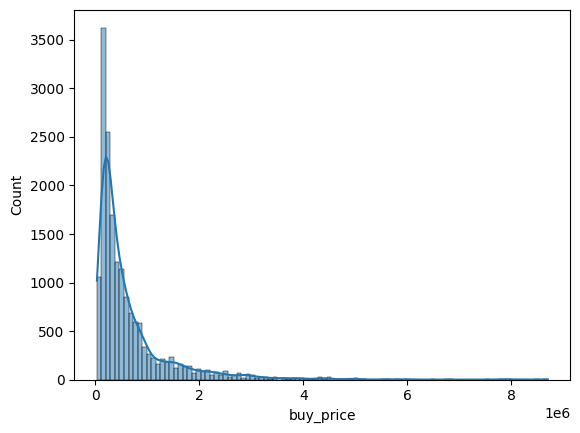

In [81]:

sns.histplot(train_set[target],bins=100,kde=True);


Vemos que la distribución del **target** no tiene una distribución gaussiana pero al no ser un problema de clasificación puede que no tengamos que tocarlo.

Se confirma al ver que tiene asimetría positiva y curtosis

In [82]:
train_set[target].describe()


count    1.739300e+04
mean     6.483047e+05
std      7.739114e+05
min      3.600000e+04
25%      1.969990e+05
50%      3.700000e+05
75%      7.550000e+05
max      8.700000e+06
Name: buy_price, dtype: float64

In [83]:
tb.describe_df(train_set[[target]])


,COL_N,buy_price
0,DATA_TYPE,int64
1,MISSINGS (%),0.0
2,UNIQUE_VALUES,2150
3,CARDIN (%),12.36


No podemos descartar que tenga valores atípicos (outliyers)

Empezamos con una visualización masiva y rápida tanto de las variables como de sus  correlaciones.

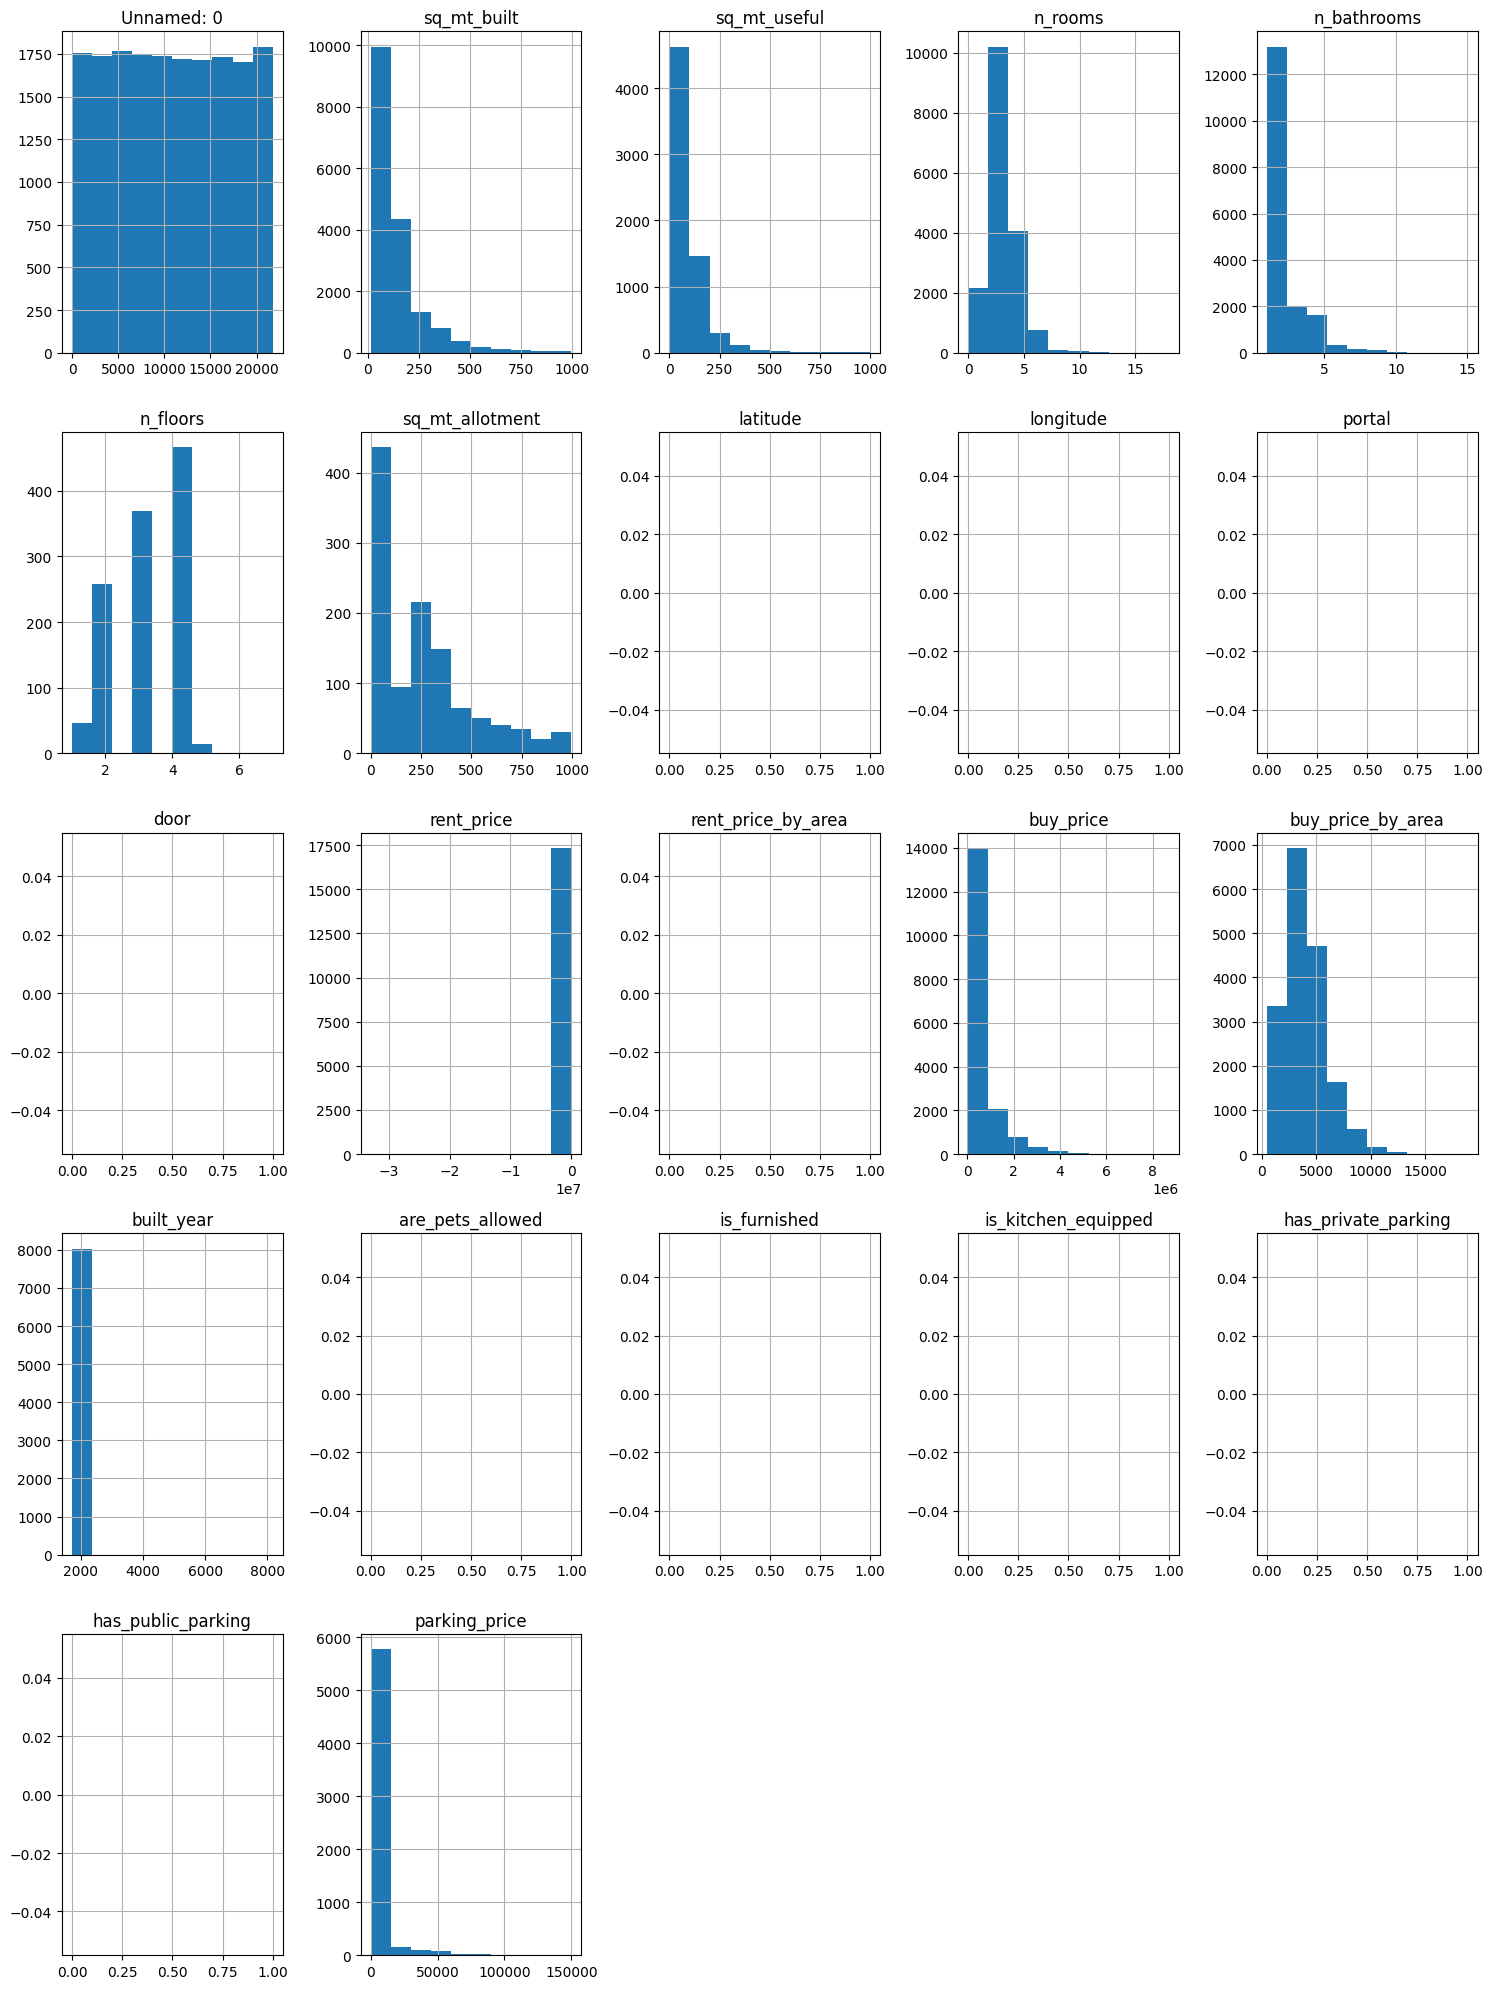

In [84]:
train_set.hist(figsize=(15,20))
plt.tight_layout();

Vemos ya algunas cosas interesantes como que *Unnamed* no aportará nada y hay muchas no numéricas.

Veamos ahora de forma masiva las correlaciones entre ellas.

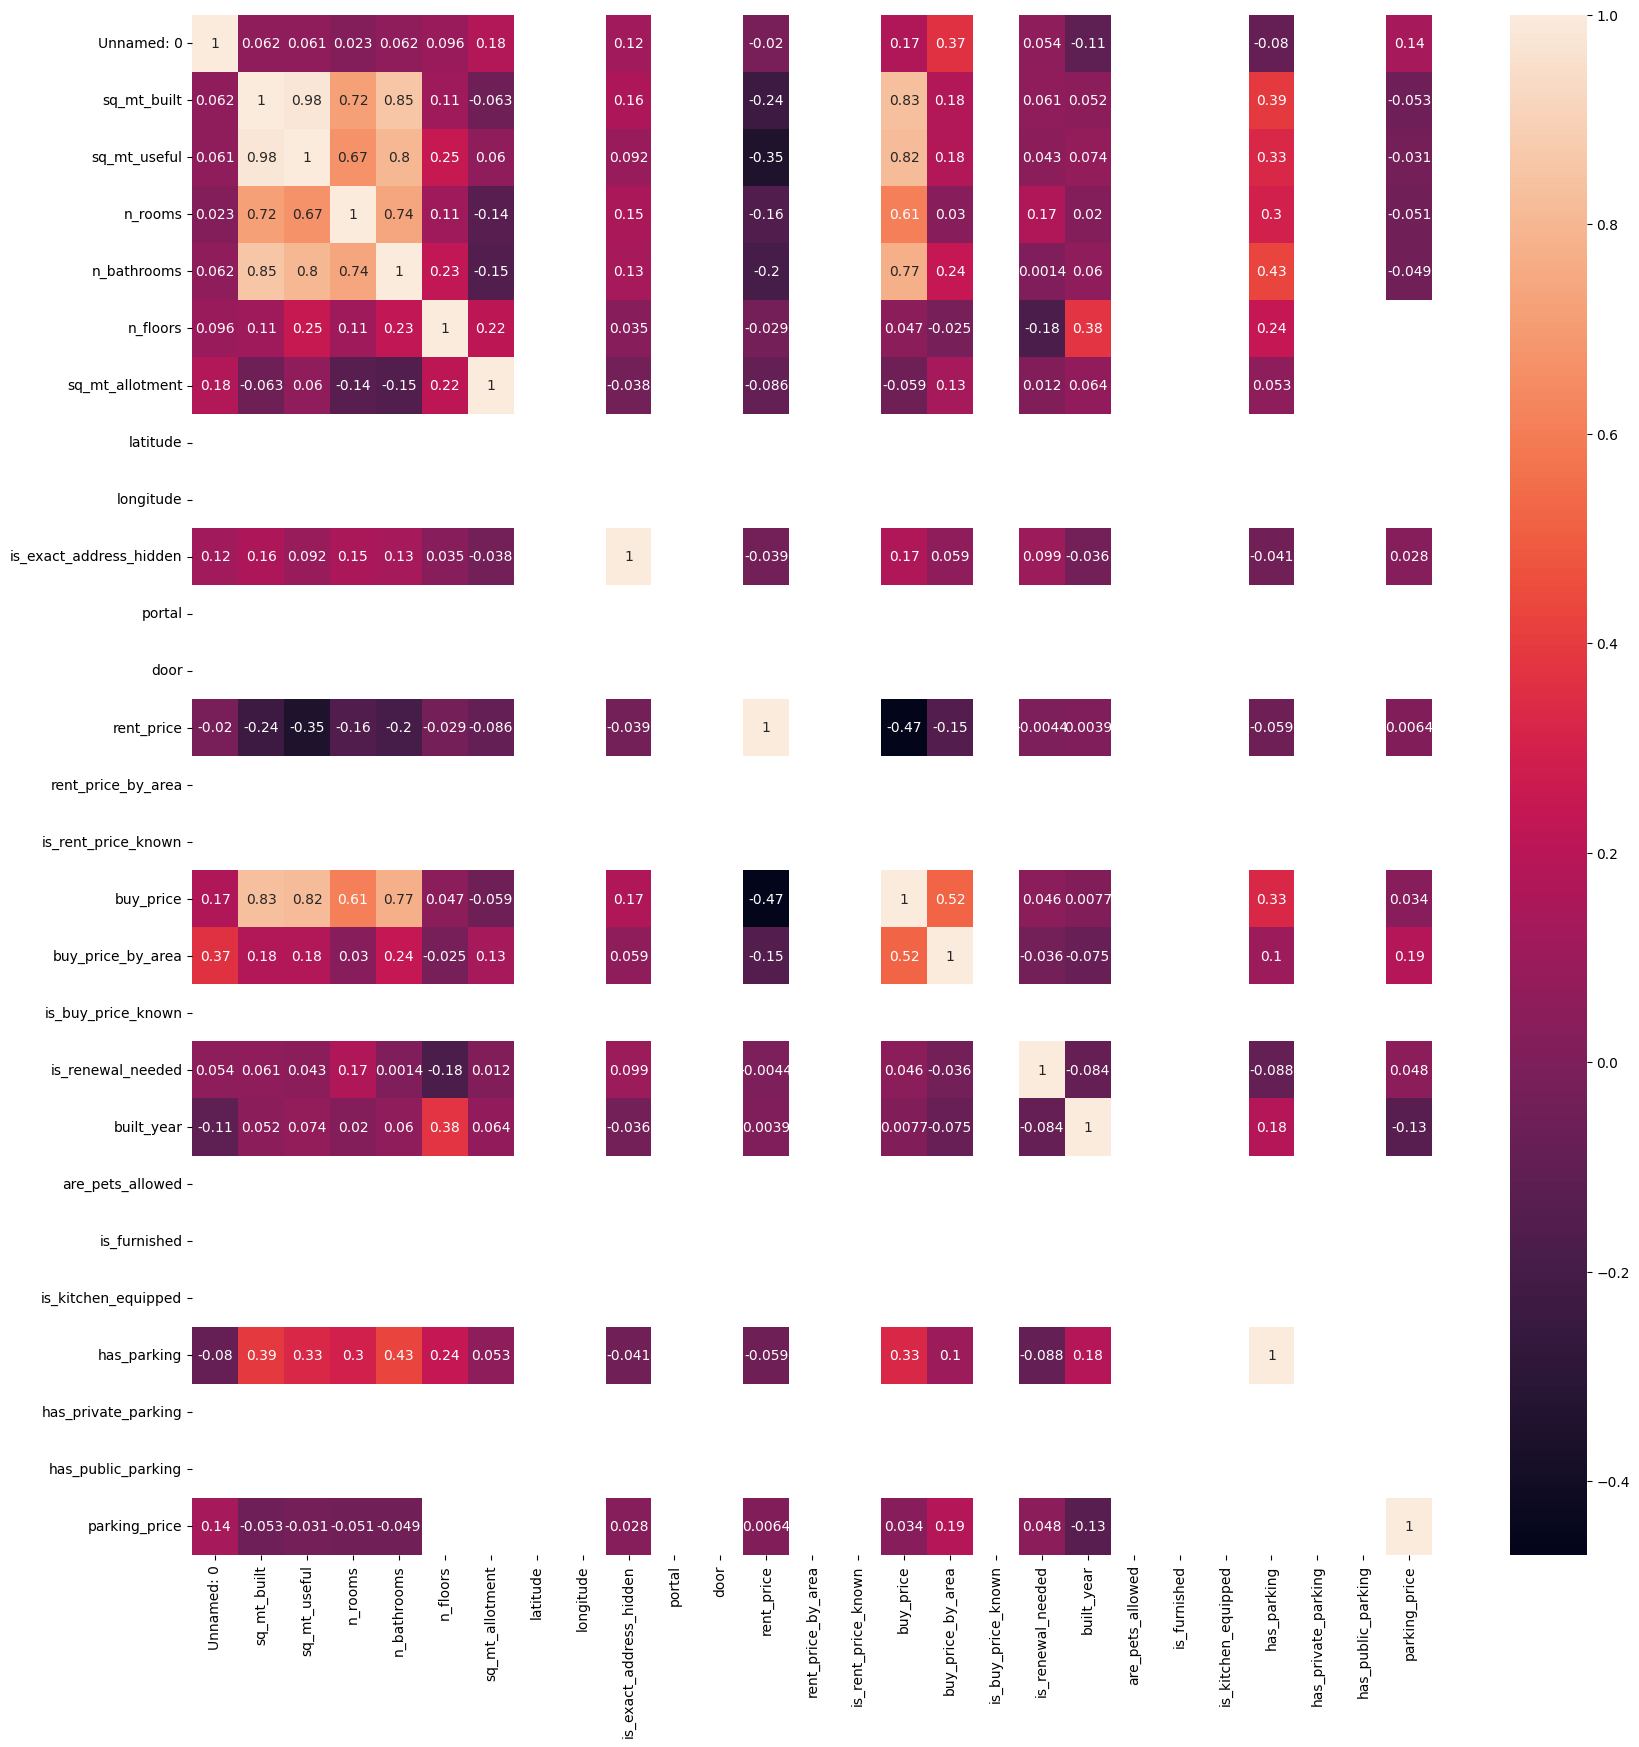

In [85]:
plt.figure(figsize= (20, 20))
sns.heatmap(train_set.corr(numeric_only= True), annot= True);

Como era de esperar vemos algunas variables con correlaciones ciertamente altas  otras sin correlación. Luego las trataremos todas.

Ahora veamos qué valores únicos tiene cada variable, lo que nos da una idea del tipo de variable (sobre todo si es numérica o booleana) y de si hay missings.

In [86]:
valores_unicos = {col: train_set[col].nunique() for col in train_set.columns} 
valores_unicos

{'Unnamed: 0': 17393,
 'title': 9042,
 'subtitle': 146,
 'sq_mt_built': 645,
 'sq_mt_useful': 388,
 'n_rooms': 18,
 'n_bathrooms': 15,
 'n_floors': 6,
 'sq_mt_allotment': 322,
 'latitude': 0,
 'longitude': 0,
 'raw_address': 8147,
 'is_exact_address_hidden': 2,
 'street_name': 5409,
 'street_number': 379,
 'portal': 0,
 'floor': 19,
 'is_floor_under': 2,
 'door': 0,
 'neighborhood_id': 126,
 'operation': 1,
 'rent_price': 1548,
 'rent_price_by_area': 0,
 'is_rent_price_known': 1,
 'buy_price': 2150,
 'buy_price_by_area': 5279,
 'is_buy_price_known': 1,
 'house_type_id': 4,
 'is_renewal_needed': 2,
 'is_new_development': 2,
 'built_year': 154,
 'has_central_heating': 2,
 'has_individual_heating': 2,
 'are_pets_allowed': 0,
 'has_ac': 1,
 'has_fitted_wardrobes': 1,
 'has_lift': 2,
 'is_exterior': 2,
 'has_garden': 1,
 'has_pool': 1,
 'has_terrace': 1,
 'has_balcony': 1,
 'has_storage_room': 1,
 'is_furnished': 0,
 'is_kitchen_equipped': 0,
 'is_accessible': 1,
 'has_green_zones': 1,
 'en

Usamos esta función de clasificación masiva de las features para complementar el punto anterior antes de decidir cómo consideramos a cada variable.

In [87]:
tb.tipifica_variables(train_set, 5, 0.10) 

,nombre_variable,tipo_sugerido
0,Unnamed: 0,Numérica Continua
1,title,Numérica Continua
2,subtitle,Numérica Continua
3,sq_mt_built,Numérica Continua
4,sq_mt_useful,Numérica Continua
5,n_rooms,Numérica Continua
6,n_bathrooms,Numérica Discreta
7,n_floors,Numérica Discreta
8,sq_mt_allotment,Numérica Continua
9,latitude,Categórica


Ya vemos que algunas variables que no son *object* las clasifica como categóricas, es por la fórmula usada, pero tomamos nota porque las convertiremos en booleanas.  Son aquellas con un solo valor único, pero clasificadas como *object*.
Igualmente vemos que algunas que contienen texto con muchas entradas diferentes las considera numéricas como *title* y *subtitle*. Luego las trataremos.  

Ahora usamos otra función para ver la cardinalidad y hacernos una idea agrupada de lo que hemos estado viendo antes.

In [88]:
tb.describe_df(train_set)

,COL_N,Unnamed: 0,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,...,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
0,DATA_TYPE,int64,object,object,float64,float64,int64,float64,float64,float64,...,object,bool,float64,float64,object,float64,object,object,object,object
1,MISSINGS (%),0.0,0.0,0.0,0.609441,61.967458,0.0,0.074743,93.353648,93.474386,...,0.0,0.0,100.0,100.0,64.537458,64.537458,47.89858,47.89858,47.89858,47.89858
2,UNIQUE_VALUES,17393,9042,146,646,389,18,16,7,323,...,10,2,1,1,3,76,3,3,3,3
3,CARDIN (%),100.0,51.99,0.84,3.71,2.23,0.1,0.09,0.03,1.85,...,0.06,0.01,0.0,0.0,0.01,0.43,0.01,0.01,0.01,0.01


Veamos ahora los missings ordenados de más a menos missings.

In [89]:
# Llamar a la función para saber los missins ordenados
missing_data = tb.obtener_datos_faltantes(train_set)
missing_data.head(50)

,Total Missing Data,Nulls Percent
rent_price_by_area,17393,1.000000
latitude,17393,1.000000
are_pets_allowed,17393,1.000000
has_private_parking,17393,1.000000
is_kitchen_equipped,17393,1.000000
has_public_parking,17393,1.000000
door,17393,1.000000
portal,17393,1.000000
longitude,17393,1.000000
is_furnished,17393,1.000000


Empezamos a crear nuestra lista de columnas a eliminar.
Primero *Unnamed: 0* que no aporta nada.

In [90]:
columns_to_exclude = ['Unnamed: 0']

In [91]:
columns_to_exclude

['Unnamed: 0']

Hemos visto que muchas columnas no tienen datos, las metemos en una lista.

In [92]:
# Llamamos a la función de filtrado para ver las columnas que nos quedan.
train_set_remainig = tb.filtrar_columnas(train_set, columns_to_exclude) 
train_set_remainig.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17393 entries, 1948 to 15796
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   title                         17393 non-null  object 
 1   subtitle                      17393 non-null  object 
 2   sq_mt_built                   17287 non-null  float64
 3   sq_mt_useful                  6615 non-null   float64
 4   n_rooms                       17393 non-null  int64  
 5   n_bathrooms                   17380 non-null  float64
 6   n_floors                      1156 non-null   float64
 7   sq_mt_allotment               1135 non-null   float64
 8   latitude                      0 non-null      float64
 9   longitude                     0 non-null      float64
 10  raw_address                   13072 non-null  object 
 11  is_exact_address_hidden       17393 non-null  bool   
 12  street_name                   12725 non-null  object 
 13  str

In [93]:
columns_no_data = df.columns[df.isnull().all()].tolist()

In [94]:
columns_no_data

['latitude',
 'longitude',
 'portal',
 'door',
 'rent_price_by_area',
 'are_pets_allowed',
 'is_furnished',
 'is_kitchen_equipped',
 'has_private_parking',
 'has_public_parking']

La fusionamos con la lista de columnas a excluir.

In [95]:
columns_to_exclude = columns_to_exclude + columns_no_data

In [96]:
columns_to_exclude

['Unnamed: 0',
 'latitude',
 'longitude',
 'portal',
 'door',
 'rent_price_by_area',
 'are_pets_allowed',
 'is_furnished',
 'is_kitchen_equipped',
 'has_private_parking',
 'has_public_parking']

In [97]:
# Llamamos a la función de filtrado para ver las columnas que nos quedan.
train_set_remaining = tb.filtrar_columnas(train_set, columns_to_exclude) 
train_set_remaining.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17393 entries, 1948 to 15796
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   title                         17393 non-null  object 
 1   subtitle                      17393 non-null  object 
 2   sq_mt_built                   17287 non-null  float64
 3   sq_mt_useful                  6615 non-null   float64
 4   n_rooms                       17393 non-null  int64  
 5   n_bathrooms                   17380 non-null  float64
 6   n_floors                      1156 non-null   float64
 7   sq_mt_allotment               1135 non-null   float64
 8   raw_address                   13072 non-null  object 
 9   is_exact_address_hidden       17393 non-null  bool   
 10  street_name                   12725 non-null  object 
 11  street_number                 5048 non-null   object 
 12  floor                         15286 non-null  object 
 13  is_

Vemos que las columnas 'sq_mt_allotment' y 'n_floors' tienen muchos missings, por lo que las añadimos a las columnas a eliminar.

También añadimos las columnas que consideramos que no aportan info adicional como nombre de calle, número del portal, etc:


    - title
    - street_number
    - street_name
    - rent_price
    - raw_address
    - is_exact_address_hidden
    - is_rent_price_known
    - is_buy_price_known

In [98]:
columns_to_exclude_add = ['sq_mt_allotment','n_floors','title','street_number','street_name','rent_price','raw_address','is_exact_address_hidden','is_rent_price_known','is_buy_price_known']

Al igual que antes las añadimos a la lista de columnas a excluir.

In [99]:
columns_to_exclude = columns_to_exclude + columns_to_exclude_add

In [100]:
columns_to_exclude

['Unnamed: 0',
 'latitude',
 'longitude',
 'portal',
 'door',
 'rent_price_by_area',
 'are_pets_allowed',
 'is_furnished',
 'is_kitchen_equipped',
 'has_private_parking',
 'has_public_parking',
 'sq_mt_allotment',
 'n_floors',
 'title',
 'street_number',
 'street_name',
 'rent_price',
 'raw_address',
 'is_exact_address_hidden',
 'is_rent_price_known',
 'is_buy_price_known']

Veamos de nuevo las variables que tienen % de missings.  
Para ello vamos a ir creando un listado de columnas no excluidas y el dataframe con las columnas no excluidas para ir trabajando con ellos.


In [101]:
# Llamamos a la función de filtrado para ver las columnas que nos quedan.
train_set_remaining= tb.filtrar_columnas(train_set, columns_to_exclude) 
train_set_remaining.info()


<class 'pandas.core.frame.DataFrame'>
Index: 17393 entries, 1948 to 15796
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   subtitle                      17393 non-null  object 
 1   sq_mt_built                   17287 non-null  float64
 2   sq_mt_useful                  6615 non-null   float64
 3   n_rooms                       17393 non-null  int64  
 4   n_bathrooms                   17380 non-null  float64
 5   floor                         15286 non-null  object 
 6   is_floor_under                16442 non-null  object 
 7   neighborhood_id               17393 non-null  object 
 8   operation                     17393 non-null  object 
 9   buy_price                     17393 non-null  int64  
 10  buy_price_by_area             17393 non-null  int64  
 11  house_type_id                 17071 non-null  object 
 12  is_renewal_needed             17393 non-null  bool   
 13  is_

In [102]:
train_set_remaining.head(5)

,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,floor,is_floor_under,neighborhood_id,operation,buy_price,...,is_accessible,has_green_zones,energy_certificate,has_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
id,,,,,,,,,,,,,,,,,,,,,
1948,"Barrio de Salamanca, Madrid",404.0,NaN,5,3.0,2,False,Neighborhood 102: Recoletos (8392.43 €/m2) - D...,sale,4350000,...,NaN,NaN,en trámite,True,False,95000.0,False,False,True,False
21383,"San Andrés, Madrid",75.0,NaN,3,1.0,3,False,Neighborhood 134: San Andrés (1617.18 €/m2) - ...,sale,117300,...,NaN,NaN,E,False,NaN,NaN,NaN,NaN,NaN,NaN
2226,"Recoletos, Madrid",176.0,NaN,3,4.0,5,False,Neighborhood 102: Recoletos (8392.43 €/m2) - D...,sale,1460000,...,True,NaN,no indicado,True,False,80000.0,NaN,NaN,NaN,NaN
5202,"San Isidro, Madrid",70.0,NaN,3,1.0,1,False,Neighborhood 19: San Isidro (2323.93 €/m2) - D...,sale,220000,...,NaN,NaN,no indicado,False,NaN,NaN,NaN,NaN,NaN,NaN
15567,"Latina, Madrid",75.0,NaN,3,1.0,8,False,Neighborhood 67: Aluche (2190.48 €/m2) - Distr...,sale,202000,...,NaN,NaN,en trámite,False,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
# Llamar a la función para saber los missins ordenados
missing_data = tb.obtener_datos_faltantes(train_set_remaining)
missing_data.head(50)

,Total Missing Data,Nulls Percent
has_garden,16148,0.928419
has_balcony,14736,0.847237
has_green_zones,14181,0.815328
is_accessible,14151,0.813603
has_pool,13256,0.762146
has_storage_room,11245,0.646524
parking_price,11225,0.645375
is_parking_included_in_price,11225,0.645375
sq_mt_useful,10778,0.619675
has_terrace,9776,0.562065


In [104]:
train_set_remaining.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 17393 entries, 1948 to 15796
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   subtitle                      17393 non-null  object 
 1   sq_mt_built                   17287 non-null  float64
 2   sq_mt_useful                  6615 non-null   float64
 3   n_rooms                       17393 non-null  int64  
 4   n_bathrooms                   17380 non-null  float64
 5   floor                         15286 non-null  object 
 6   is_floor_under                16442 non-null  object 
 7   neighborhood_id               17393 non-null  object 
 8   operation                     17393 non-null  object 
 9   buy_price                     17393 non-null  int64  
 10  buy_price_by_area             17393 non-null  int64  
 11  house_type_id                 17071 non-null  object 
 12  is_renewal_needed             17393 non-null  bool   
 13  is_

Hemos visto que muchas columnas categóricas tiene NaN en lugar de False.  
Vamos a ver la descripcción para ver si nen caso de no aportan eliminarlas o en caso de si aportar info, cambiar el NaN por False.

In [105]:
train_set_remaining.dtypes
for col in train_set_remaining:
    print(train_set_remaining[col].value_counts())
    print('')


subtitle
Chamartín, Madrid                           671
Moncloa, Madrid                             622
Chamberí, Madrid                            468
Centro, Madrid                              423
Hortaleza, Madrid                           405
                                           ... 
Barajas, Madrid                               6
Campo de las Naciones-Corralejos, Madrid      5
Timón, Madrid                                 4
Casco Histórico de Barajas, Madrid            4
Cuatro Vientos, Madrid                        1
Name: count, Length: 146, dtype: int64

sq_mt_built
70.0     408
60.0     381
80.0     339
65.0     298
75.0     289
        ... 
744.0      1
734.0      1
660.0      1
528.0      1
758.0      1
Name: count, Length: 645, dtype: int64

sq_mt_useful
70.0     215
60.0     183
65.0     171
80.0     169
90.0     168
        ... 
480.0      1
305.0      1
366.0      1
193.0      1
286.0      1
Name: count, Length: 388, dtype: int64

n_rooms
3     5771
2     4440
4 

Vemos varias cosas interesantes:  

   __operation__ no aporta nada, todo son ventas.  
   __Subtitle__ es el barrio.  
   __Floor__ mezcla valores numéricos con categóricos.  
   __neighborhood_id__ está clasificado por números, por lo que podríamos eliminar la descrición tras el número.  
   __built_year__ tiene algún año raro como el 8170 que es un error.  


Por ello vamos a añadir __operation__ a la lista a eliminar  y a listar las que indican si el inmueble tiene o no algo, en las que solo hay _True_ pq posiblemente se pueda sustituir el _Nan_ por _False_:

    * has_ac
    * has_fitted_wardrobes
    * has_lift
    * is_exterior
    * has_garden
    * has_pool
    * has_terrace
    * has_balcony
    * has_storage_room
    * is_accessible
    * has_green_zones





Añadimos __operation__ a la lista de exclusión

In [106]:
columns_to_exclude.append('operation')

In [107]:
columns_to_exclude

['Unnamed: 0',
 'latitude',
 'longitude',
 'portal',
 'door',
 'rent_price_by_area',
 'are_pets_allowed',
 'is_furnished',
 'is_kitchen_equipped',
 'has_private_parking',
 'has_public_parking',
 'sq_mt_allotment',
 'n_floors',
 'title',
 'street_number',
 'street_name',
 'rent_price',
 'raw_address',
 'is_exact_address_hidden',
 'is_rent_price_known',
 'is_buy_price_known',
 'operation']

Hacemos una lista y sustituimos los NaN por False.

In [108]:
NaNlist=['has_ac','has_fitted_wardrobes','has_lift','is_exterior','has_garden','has_pool','has_terrace','has_balcony','has_storage_room','is_accessible','has_green_zones']
for col in NaNlist:
    train_set[col]=train_set[col].fillna(False)
train_set.head()


,Unnamed: 0,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,latitude,...,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
id,,,,,,,,,,,,,,,,,,,,,
1948,19794,Piso en venta en Recoletos,"Barrio de Salamanca, Madrid",404.0,NaN,5,3.0,NaN,NaN,NaN,...,en trámite,True,NaN,NaN,False,95000.0,False,False,True,False
21383,359,"Piso en venta en calle Villavendimio, 15","San Andrés, Madrid",75.0,NaN,3,1.0,NaN,NaN,NaN,...,E,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2226,19516,Dúplex en venta en calle Claudio Coello,"Recoletos, Madrid",176.0,NaN,3,4.0,NaN,NaN,NaN,...,no indicado,True,NaN,NaN,False,80000.0,NaN,NaN,NaN,NaN
5202,16540,"Piso en venta en calle Doctor Zofío, 5","San Isidro, Madrid",70.0,NaN,3,1.0,NaN,NaN,NaN,...,no indicado,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15567,6175,Piso en venta en Urb. Urbanización con piscina...,"Latina, Madrid",75.0,NaN,3,1.0,NaN,NaN,NaN,...,en trámite,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Hacemos lo mismo para el test_set

In [109]:
for col in NaNlist:
    test_set[col]=test_set[col].fillna(False)
test_set.head()


,Unnamed: 0,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,latitude,...,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
id,,,,,,,,,,,,,,,,,,,,,
21258,484,Piso en venta en palomares,"San Andrés, Madrid",65.0,NaN,2,1.0,NaN,NaN,NaN,...,E,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3231,18511,Dúplex en venta en orellana,"Chueca-Justicia, Madrid",133.0,120.0,2,3.0,NaN,NaN,NaN,...,E,False,NaN,NaN,NaN,NaN,False,False,True,False
18791,2951,Piso en venta en calle Sorgo,"Valdeacederas, Madrid",41.0,35.0,1,1.0,NaN,NaN,NaN,...,E,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7376,14366,Dúplex en venta en calle de Gabriel Lobo,"El Viso, Madrid",119.0,NaN,3,2.0,NaN,NaN,NaN,...,D,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12368,9374,Piso en venta en Mirasierra,"Fuencarral, Madrid",120.0,76.0,3,2.0,NaN,NaN,NaN,...,no indicado,True,NaN,NaN,True,0.0,NaN,NaN,NaN,NaN


De las columnas que no vamos a eliminar hay algunas que nos parece pueden tener correlaciones altas entre ellas y por lo tanto no aportar más información que la otra. 
Veamos primero los metros cuadrados construidos vs útiles y si tiene parking en el precio vs el precio del parking.

Y hay otra que por su nombre parece estar correlada con el target, se trata de *buy_price_by_area*, vamos a verla.

In [110]:
correlation_sqm = train_set[['sq_mt_built','sq_mt_useful']].corr()
correlation_parking = train_set[['is_parking_included_in_price','parking_price']].corr()
correlation_price = train_set[['buy_price_by_area',target]].corr()

print(correlation_sqm)
print(correlation_parking)
print(correlation_price)




              sq_mt_built  sq_mt_useful
sq_mt_built      1.000000      0.981107
sq_mt_useful     0.981107      1.000000
                              is_parking_included_in_price  parking_price
is_parking_included_in_price                       1.00000       -0.81449
parking_price                                     -0.81449        1.00000
                   buy_price_by_area  buy_price
buy_price_by_area           1.000000   0.520957
buy_price                   0.520957   1.000000


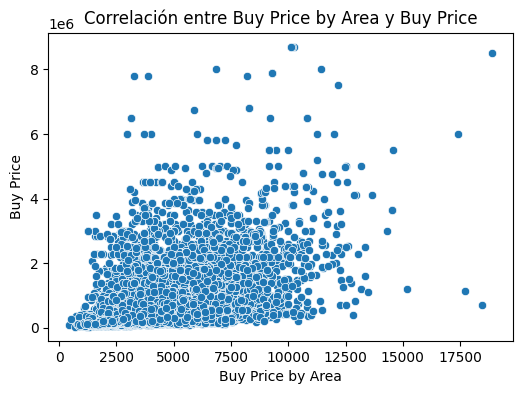

In [111]:
# Veamos la correlacíon del precio por area con el precio de la compra.
plt.figure(figsize=(6, 4))
sns.scatterplot(x='buy_price_by_area', y='buy_price', data=train_set) 
# Añadir título y etiquetas
plt.title('Correlación entre Buy Price by Area y Buy Price')
plt.xlabel('Buy Price by Area')
plt.ylabel('Buy Price') # Mostrar el gráfico
plt.show()

Vemos que hay correlación entre precio por area y el target. Nos la vamos a quedar.  
De las otras correlaciones entre variables vemos que la correlación es alta por lo que nos quedamos con la que menos missings tiene en el caso de los metros cuadrados y en con si tiene o no parking.

In [112]:
# Añadimos a la lista de exclución las columnas que vamos a usar.
columns_to_exclude.append('sq_mt_useful')
columns_to_exclude.append('parking_price')

In [113]:
columns_to_exclude

['Unnamed: 0',
 'latitude',
 'longitude',
 'portal',
 'door',
 'rent_price_by_area',
 'are_pets_allowed',
 'is_furnished',
 'is_kitchen_equipped',
 'has_private_parking',
 'has_public_parking',
 'sq_mt_allotment',
 'n_floors',
 'title',
 'street_number',
 'street_name',
 'rent_price',
 'raw_address',
 'is_exact_address_hidden',
 'is_rent_price_known',
 'is_buy_price_known',
 'operation',
 'sq_mt_useful',
 'parking_price']

Veamos como quedaría el dataframe si hacemos los cambios anteriores.

In [114]:
# Llamamos a la función de filtrado para ver las columnas que nos quedan.
train_set_remaining= tb.filtrar_columnas(train_set, columns_to_exclude) 
train_set_remaining.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17393 entries, 1948 to 15796
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   subtitle                      17393 non-null  object 
 1   sq_mt_built                   17287 non-null  float64
 2   n_rooms                       17393 non-null  int64  
 3   n_bathrooms                   17380 non-null  float64
 4   floor                         15286 non-null  object 
 5   is_floor_under                16442 non-null  object 
 6   neighborhood_id               17393 non-null  object 
 7   buy_price                     17393 non-null  int64  
 8   buy_price_by_area             17393 non-null  int64  
 9   house_type_id                 17071 non-null  object 
 10  is_renewal_needed             17393 non-null  bool   
 11  is_new_development            16584 non-null  object 
 12  built_year                    8036 non-null   float64
 13  has

In [115]:
# Llamar a la función 
missing_data = tb.obtener_datos_faltantes(train_set_remaining)
missing_data.head(20)

,Total Missing Data,Nulls Percent
is_parking_included_in_price,11225,0.645375
built_year,9357,0.537975
is_orientation_west,8331,0.478986
is_orientation_north,8331,0.478986
is_orientation_east,8331,0.478986
is_orientation_south,8331,0.478986
has_central_heating,6487,0.372966
has_individual_heating,6487,0.372966
floor,2107,0.121141
is_floor_under,951,0.054677


Viendo la descripción del dataset la feature __is_floor_under__ significa que está en un sótano o por debajo del nivel de la calle.  
Vamos a ver si el is_floor_under está correlacionado con el target.

In [116]:
train_set_remaining.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17393 entries, 1948 to 15796
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   subtitle                      17393 non-null  object 
 1   sq_mt_built                   17287 non-null  float64
 2   n_rooms                       17393 non-null  int64  
 3   n_bathrooms                   17380 non-null  float64
 4   floor                         15286 non-null  object 
 5   is_floor_under                16442 non-null  object 
 6   neighborhood_id               17393 non-null  object 
 7   buy_price                     17393 non-null  int64  
 8   buy_price_by_area             17393 non-null  int64  
 9   house_type_id                 17071 non-null  object 
 10  is_renewal_needed             17393 non-null  bool   
 11  is_new_development            16584 non-null  object 
 12  built_year                    8036 non-null   float64
 13  has

In [117]:
train_set_remaining.is_floor_under.value_counts()

is_floor_under
False    14426
True      2016
Name: count, dtype: int64

In [118]:
correlation_floor = train_set_remaining[['is_floor_under',target]].corr()
print(correlation_floor)


                is_floor_under  buy_price
is_floor_under        1.000000  -0.152344
buy_price            -0.152344   1.000000


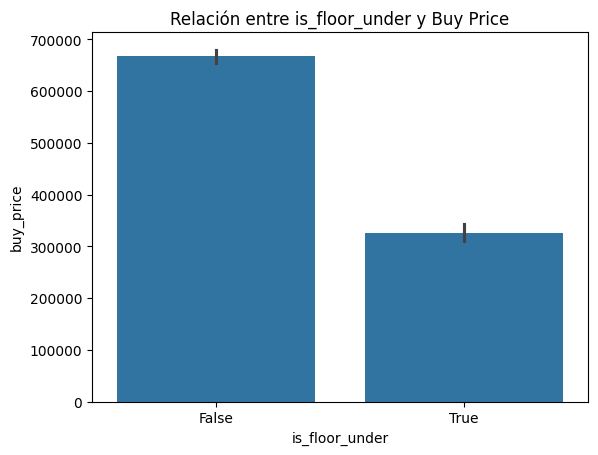

In [119]:
# Crear un gráfico de dispersión (scatter plot) para visualizar la relación
sns.barplot(x='is_floor_under', y=target, data=train_set_remaining)
# Añadir títulos y etiquetas
plt.title('Relación entre is_floor_under y Buy Price')
plt.xlabel('is_floor_under')
plt.ylabel(target) 
# Mostrar el gráfico
plt.show();

Tiene poca correlación aunque negativa, como podríamos esperar, posiblemente prescindamos de ella.


Vamos a ver qué valores tienen las columnas que más missings presentan y además la de is_floor_under que tiene poco poder explicativo.

In [120]:
# Vamos a ver los valores que tienen los que más missings presentan, los dejamos un una lista por si lo necesitamos más adelante.
List = ['built_year','is_orientation_east','is_orientation_south','is_orientation_west','is_orientation_north','has_central_heating','has_individual_heating','floor','is_floor_under']
for feature in List:
    print(f"Value Counts para {feature}:")
    print(train_set[feature].value_counts())
    print("n")


Value Counts para built_year:
built_year
1960.0    415
1970.0    397
1900.0    360
1965.0    343
1950.0    195
         ... 
1901.0      1
1723.0      1
1882.0      1
1899.0      1
1871.0      1
Name: count, Length: 154, dtype: int64
n
Value Counts para is_orientation_east:
is_orientation_east
False    5009
True     4053
Name: count, dtype: int64
n
Value Counts para is_orientation_south:
is_orientation_south
True     4607
False    4455
Name: count, dtype: int64
n
Value Counts para is_orientation_west:
is_orientation_west
False    5799
True     3263
Name: count, dtype: int64
n
Value Counts para is_orientation_north:
is_orientation_north
False    6819
True     2243
Name: count, dtype: int64
n
Value Counts para has_central_heating:
has_central_heating
False    7625
True     3281
Name: count, dtype: int64
n
Value Counts para has_individual_heating:
has_individual_heating
True     7625
False    3281
Name: count, dtype: int64
n
Value Counts para floor:
floor
1                       3528
2   

Vamos a analizar un poco más las features __built_year__ puesto que el año de construcción nos parece interesante pero igual no aporta información suficiente y se puede prescindir.

In [121]:
train_set.built_year.value_counts()

built_year
1960.0    415
1970.0    397
1900.0    360
1965.0    343
1950.0    195
         ... 
1901.0      1
1723.0      1
1882.0      1
1899.0      1
1871.0      1
Name: count, Length: 154, dtype: int64

In [122]:
# Vamos a ver si el buit_year  está correlacionado con el target 
correlation_year= train_set[['built_year',target]].corr()
print(correlation_year)

            built_year  buy_price
built_year    1.000000   0.007705
buy_price     0.007705   1.000000


Parece que tiene poca correlación, habríamos esperado lo contrario. Vamos a verlo visualmente para cercionarnos.

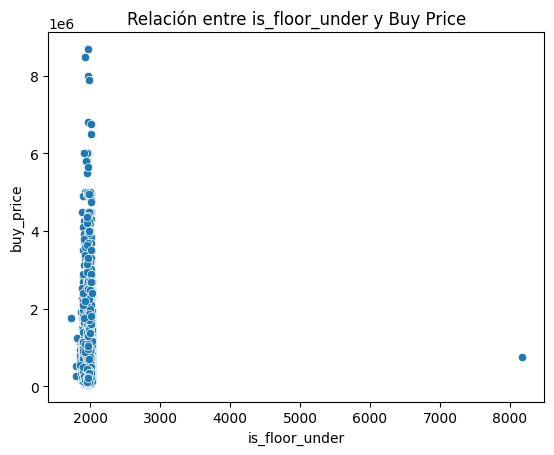

In [123]:
# Crear un gráfico de dispersión (scatter plot) para visualizar la relación
sns.scatterplot(x='built_year', y=target, data=train_set)
# Añadir títulos y etiquetas
plt.title('Relación entre is_floor_under y Buy Price')
plt.xlabel('is_floor_under')
plt.ylabel(target) 
# Mostrar el gráfico
plt.show();

Parece que hay errores, no puede haber inmuebles con fecha construcción posterior a la actulidad, 2024. Los filtramos y quitamos.

In [124]:
built_year_max= train_set.built_year.max()
built_year_max


8170.0

In [125]:
# Calculamos la media de los años de construcción, excluyendo el valor erróneo
mean_year_built = train_set[train_set['built_year'] != built_year_max]['built_year'].mean()
# Sustituimos el valor erróneo por la media
train_set.loc[train_set['built_year'] > 2024, 'built_year'] = mean_year_built

In [126]:
train_set.built_year.max()

2022.0

Hacemos lo mismo para el tet

In [127]:
test_set.loc[test_set['built_year'] > 2024, 'built_year'] = mean_year_built
test_set.built_year.max()

2022.0

Ya está arreglado, veamos de nuevo la distribución del precio según el año de construcción

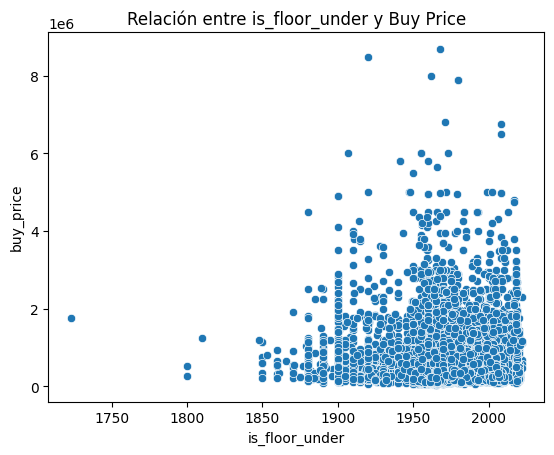

In [128]:
# Crear un gráfico de dispersión (scatter plot) para visualizar la relación
sns.scatterplot(x='built_year', y=target, data=train_set)
# Añadir títulos y etiquetas
plt.title('Relación entre is_floor_under y Buy Price')
plt.xlabel('is_floor_under')
plt.ylabel(target) 
# Mostrar el gráfico
plt.show();

In [129]:
correlation_year_2 = train_set['buy_price'].corr(train_set['built_year'])

In [130]:
print(f"El coeficiente de correlación es: {correlation_year_2}")

El coeficiente de correlación es: 0.015552501434800416


Parece que tiene poca capacidad predictiva y tiene muchos nulos, por ahora la eliminaremos.

Vamos a eliminar todas menos buy_price_by_area, que por ahora nos las quedamos.

In [131]:
columns_to_exclude_add_2=['built_year','is_orientation_east','is_orientation_south','is_orientation_west','is_orientation_north','has_individual_heating','has_central_heating','floor','is_floor_under','subtitle',]

In [132]:
columns_to_check_LR =['sq_mt_built','n_rooms']

In [133]:
columns_to_exclude = columns_to_exclude + columns_to_exclude_add_2+columns_to_check_LR

In [134]:
# Llamamos a la función de filtrado para ver las columnas que nos quedan.
train_set_remaining= tb.filtrar_columnas(train_set, columns_to_exclude) 
train_set_remaining.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17393 entries, 1948 to 15796
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   n_bathrooms                   17380 non-null  float64
 1   neighborhood_id               17393 non-null  object 
 2   buy_price                     17393 non-null  int64  
 3   buy_price_by_area             17393 non-null  int64  
 4   house_type_id                 17071 non-null  object 
 5   is_renewal_needed             17393 non-null  bool   
 6   is_new_development            16584 non-null  object 
 7   has_ac                        17393 non-null  bool   
 8   has_fitted_wardrobes          17393 non-null  bool   
 9   has_lift                      17393 non-null  bool   
 10  is_exterior                   17393 non-null  bool   
 11  has_garden                    17393 non-null  bool   
 12  has_pool                      17393 non-null  bool   
 13  has

In [135]:
len(columns_to_exclude)

36

Vamos a ver cómo queda el data frame y si hay más variables que analizar.

In [136]:
train_set_remaining.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17393 entries, 1948 to 15796
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   n_bathrooms                   17380 non-null  float64
 1   neighborhood_id               17393 non-null  object 
 2   buy_price                     17393 non-null  int64  
 3   buy_price_by_area             17393 non-null  int64  
 4   house_type_id                 17071 non-null  object 
 5   is_renewal_needed             17393 non-null  bool   
 6   is_new_development            16584 non-null  object 
 7   has_ac                        17393 non-null  bool   
 8   has_fitted_wardrobes          17393 non-null  bool   
 9   has_lift                      17393 non-null  bool   
 10  is_exterior                   17393 non-null  bool   
 11  has_garden                    17393 non-null  bool   
 12  has_pool                      17393 non-null  bool   
 13  has

Seguimos analizando el data set train_set, el filtro anterior era solo para ver cóm quedaría tras procesarlo si eliminamos las columnas seleccionadas hasta el momento.

Ahora vamos a analizar __neighborhood_id__ para ver si podemos sacar los códigos de vencidario y distrito.

In [137]:
train_set.neighborhood_id.value_counts()

neighborhood_id
Neighborhood 23: Malasaña-Universidad (5196.25 €/m2) - District 4: Centro                372
Neighborhood 59: Conde Orgaz-Piovera (4275.46 €/m2) - District 9: Hortaleza              368
Neighborhood 28: El Viso (6255.45 €/m2) - District 5: Chamartín                          365
Neighborhood 32: Almagro (6564.27 €/m2) - District 6: Chamberí                           341
Neighborhood 72: Aravaca (3600.4 €/m2) - District 11: Moncloa                            327
                                                                                        ... 
Neighborhood 80: Horcajo (None €/m2) - District 12: Moratalaz                             10
Neighborhood 9: Campo de las Naciones-Corralejos (3417.44 €/m2) - District 2: Barajas      7
Neighborhood 11: Timón (2879.88 €/m2) - District 2: Barajas                                6
Neighborhood 10: Casco Histórico de Barajas (3100.87 €/m2) - District 2: Barajas           5
Neighborhood 65: Cuatro Vientos (None €/m2) - District

Vemos que tiene dos códigos interesantes, el Neighborhood id y el Discrict id. 
La localización suele ser muy importante para fijar el precio de un piso, por ello los vamos a tratar como variables separadas.
Dividiremos el  neighbourhood_id  en barrio y distrito (columnas separadas) con su cógido sustituyendo al neigborhood_id anterior.

A continuación, dividiremos neighbourhood_id  en barrio y distrito (columnas separadas).

In [138]:

train_set['district_id']=train_set['neighborhood_id'].copy()
train_set.district_id=train_set.district_id.str.extract(r'(District \d+)')
train_set.neighborhood_id=train_set.neighborhood_id.str.extract(r'(Neighborhood \d+)')
train_set.district_id=train_set.district_id.str.extract(r'(\d+)')
train_set.neighborhood_id=train_set.neighborhood_id.str.extract(r'(\d+)')
train_set

,Unnamed: 0,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,latitude,...,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east,district_id
id,,,,,,,,,,,,,,,,,,,,,
1948,19794,Piso en venta en Recoletos,"Barrio de Salamanca, Madrid",404.0,NaN,5,3.0,NaN,NaN,NaN,...,True,NaN,NaN,False,95000.0,False,False,True,False,15
21383,359,"Piso en venta en calle Villavendimio, 15","San Andrés, Madrid",75.0,NaN,3,1.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
2226,19516,Dúplex en venta en calle Claudio Coello,"Recoletos, Madrid",176.0,NaN,3,4.0,NaN,NaN,NaN,...,True,NaN,NaN,False,80000.0,NaN,NaN,NaN,NaN,15
5202,16540,"Piso en venta en calle Doctor Zofío, 5","San Isidro, Madrid",70.0,NaN,3,1.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
15567,6175,Piso en venta en Urb. Urbanización con piscina...,"Latina, Madrid",75.0,NaN,3,1.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11965,9777,Piso en venta en Conde Orgaz-Piovera,"Hortaleza, Madrid",286.0,NaN,4,4.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
21576,166,Piso en venta en Benimamet,"San Cristóbal, Madrid",69.0,NaN,3,1.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
5391,16351,Piso en venta en Puerta Bonita,"Carabanchel, Madrid",118.0,111.0,3,1.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


Hacemos lo mismo para el test

In [139]:

test_set['district_id']=test_set['neighborhood_id'].copy()
test_set.district_id=test_set.district_id.str.extract(r'(District \d+)')
test_set.neighborhood_id=test_set.neighborhood_id.str.extract(r'(Neighborhood \d+)')
test_set.district_id=test_set.district_id.str.extract(r'(\d+)')
test_set.neighborhood_id=test_set.neighborhood_id.str.extract(r'(\d+)')
test_set

,Unnamed: 0,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,latitude,...,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east,district_id
id,,,,,,,,,,,,,,,,,,,,,
21258,484,Piso en venta en palomares,"San Andrés, Madrid",65.0,NaN,2,1.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
3231,18511,Dúplex en venta en orellana,"Chueca-Justicia, Madrid",133.0,120.0,2,3.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,False,False,True,False,4
18791,2951,Piso en venta en calle Sorgo,"Valdeacederas, Madrid",41.0,35.0,1,1.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
7376,14366,Dúplex en venta en calle de Gabriel Lobo,"El Viso, Madrid",119.0,NaN,3,2.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
12368,9374,Piso en venta en Mirasierra,"Fuencarral, Madrid",120.0,76.0,3,2.0,NaN,NaN,NaN,...,True,NaN,NaN,True,0.0,NaN,NaN,NaN,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,21256,"Piso en venta en calle Diálogo, 7","El Cañaveral - Los Berrocales, Madrid",82.0,NaN,3,2.0,NaN,NaN,NaN,...,True,NaN,NaN,True,0.0,NaN,NaN,NaN,NaN,19
15189,6553,"Piso en venta en calle Magín Calvo, 26","Puerta del Ángel, Madrid",72.0,70.0,1,1.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
968,20774,Piso en venta en Delicias,"Arganzuela, Madrid",50.0,NaN,2,1.0,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


Veamos la correlacion de district y neighborhood

In [140]:
correlation_district_neigh= train_set[['district_id','neighborhood_id']].corr()
print(correlation_district_neigh)

                 district_id  neighborhood_id
district_id         1.000000         0.996718
neighborhood_id     0.996718         1.000000


In [141]:
print(train_set.district_id.nunique())
print(train_set.neighborhood_id.nunique())

20
126


Eliminamos neighborhood que tiene más categorías.

In [142]:
columns_to_excude = columns_to_exclude.append('neighborhood_id')

Vamos a eliminar también las filas con nulos de house_type_i y de is_new_development, sq_mt_built y n_bathrooms. El dataset es suficientemente grande para permitírnoslo.

In [143]:
train_set = train_set.dropna(subset=['house_type_id','is_new_development',])
train_set = train_set.dropna(subset=['sq_mt_built','n_bathrooms',])

Hacemos lo mismo con el test_set

In [144]:
test_set = test_set.dropna(subset=['house_type_id','is_new_development',])
test_set = test_set.dropna(subset=['sq_mt_built','n_bathrooms',])

In [145]:
# Llamamos a la función de filtrado para ver las columnas que nos quedan.
train_set_remaining= tb.filtrar_columnas(train_set, columns_to_exclude) 
train_set_remaining.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16160 entries, 1948 to 15796
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   n_bathrooms                   16160 non-null  float64
 1   buy_price                     16160 non-null  int64  
 2   buy_price_by_area             16160 non-null  int64  
 3   house_type_id                 16160 non-null  object 
 4   is_renewal_needed             16160 non-null  bool   
 5   is_new_development            16160 non-null  object 
 6   has_ac                        16160 non-null  bool   
 7   has_fitted_wardrobes          16160 non-null  bool   
 8   has_lift                      16160 non-null  bool   
 9   is_exterior                   16160 non-null  bool   
 10  has_garden                    16160 non-null  bool   
 11  has_pool                      16160 non-null  bool   
 12  has_terrace                   16160 non-null  bool   
 13  has

Vamos a analizar algunas features cuyo tipo no parece ajustarse a lo que esperaríamos por el dato que contienen por si podemos transformarlas: __n_bathrooms__, __is_new_development__.

In [146]:
train_set.is_new_development.value_counts()
# Aparece como object pero es booleana, solo tiene True y False.

is_new_development
False    15002
True      1158
Name: count, dtype: int64

In [147]:
train_set.n_bathrooms.value_counts()

n_bathrooms
1.0     6564
2.0     5642
3.0     1895
4.0      901
5.0      682
6.0      289
7.0      124
8.0       42
9.0       14
11.0       3
10.0       3
14.0       1
Name: count, dtype: int64

In [148]:
train_set.is_parking_included_in_price.value_counts()

is_parking_included_in_price
True     5416
False     460
Name: count, dtype: int64

Vamos a transformar __is_new_development__ e __is_parking_included__ en booleana.
Vamos a transformar __n_batrhrooms__ , en entera.

In [149]:
train_set['is_new_development']= train_set['is_new_development'].astype(bool)
train_set['is_parking_included_in_price']= train_set['is_parking_included_in_price'].astype(bool)
train_set['n_bathrooms']= train_set['n_bathrooms'].astype(int)



In [150]:
print(train_set.is_new_development.dtype,train_set.is_parking_included_in_price.dtype)
print(train_set.n_bathrooms.dtype)


bool bool
int32


In [151]:
train_set.n_bathrooms.value_counts() # vemos que ha quedado bien.

n_bathrooms
1     6564
2     5642
3     1895
4      901
5      682
6      289
7      124
8       42
9       14
11       3
10       3
14       1
Name: count, dtype: int64

Hacemos lo mismo con el test_set

In [152]:
test_set['is_new_development']= test_set['is_new_development'].astype(bool)
test_set['is_parking_included_in_price']= test_set['is_parking_included_in_price'].astype(bool)
test_set['n_bathrooms']= test_set['n_bathrooms'].astype(int)


In [153]:
print(test_set.is_new_development.dtype,test_set.is_parking_included_in_price.dtype)
print(test_set.n_bathrooms.dtype)

bool bool
int32


In [154]:
# Llamamos a la función de filtrado para ver las columnas que nos quedan.
train_set_remaining= tb.filtrar_columnas(train_set, columns_to_exclude) 
train_set_remaining.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16160 entries, 1948 to 15796
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   n_bathrooms                   16160 non-null  int32 
 1   buy_price                     16160 non-null  int64 
 2   buy_price_by_area             16160 non-null  int64 
 3   house_type_id                 16160 non-null  object
 4   is_renewal_needed             16160 non-null  bool  
 5   is_new_development            16160 non-null  bool  
 6   has_ac                        16160 non-null  bool  
 7   has_fitted_wardrobes          16160 non-null  bool  
 8   has_lift                      16160 non-null  bool  
 9   is_exterior                   16160 non-null  bool  
 10  has_garden                    16160 non-null  bool  
 11  has_pool                      16160 non-null  bool  
 12  has_terrace                   16160 non-null  bool  
 13  has_balcony       

Vemos que nos quedan tres categóricas: __house_type_id__, __energy_certificate__ y __district_id__
Vamos a ver los valores que contienen por si luego hacemos un OneHotEncoder.
Hacemos una lista con ellas.

In [155]:
train_set.house_type_id.value_counts()


house_type_id
HouseType 1: Pisos            13443
HouseType 2: Casa o chalet     1396
HouseType 5: Áticos             782
HouseType 4: Dúplex             539
Name: count, dtype: int64

In [156]:
train_set.energy_certificate.value_counts()

energy_certificate
en trámite         8190
no indicado        2719
E                  2003
D                   848
G                   633
F                   464
A                   447
C                   442
B                   344
inmueble exento      70
Name: count, dtype: int64

In [157]:
var_cat = [col for col in train_set_remaining.columns if train_set_remaining[col].dtype == 'object']
var_cat

['house_type_id', 'energy_certificate', 'district_id']

In [158]:
tb.describe_df(train_set_remaining[var_cat])

,COL_N,house_type_id,energy_certificate,district_id
0,DATA_TYPE,object,object,object
1,MISSINGS (%),0.0,0.0,0.0
2,UNIQUE_VALUES,4,10,20
3,CARDIN (%),0.02,0.06,0.12


A las VARIABLES CATEGÓRICAS vamos a aplicarles un OneHotEncoder.

Tenemos muchas variables booleanas, vamos a transformarlas a 1 y 0 para poder procesarlas.

In [159]:
bool_transform =[] # Nos guardamos la lista para no hacer luego el logaritmo ni el StandadScaler
for column in train_set.columns: 
    if train_set[column].dtype == 'bool': 
        bool_transform.append(column)

In [160]:
bool_transform

['is_exact_address_hidden',
 'is_rent_price_known',
 'is_buy_price_known',
 'is_renewal_needed',
 'is_new_development',
 'has_ac',
 'has_fitted_wardrobes',
 'has_lift',
 'is_exterior',
 'has_garden',
 'has_pool',
 'has_terrace',
 'has_balcony',
 'has_storage_room',
 'is_accessible',
 'has_green_zones',
 'has_parking',
 'is_parking_included_in_price']

In [161]:
for column in train_set.columns: 
    if train_set[column].dtype == 'bool': 
        train_set[column] = train_set[column].astype(int)

In [162]:
for column in test_set.columns:
    if test_set[column].dtype == 'bool':
        test_set[column] = test_set[column].astype(int)

In [163]:
# Llamamos a la función de filtrado para ver las columnas que nos quedan.
train_set_remaining= tb.filtrar_columnas(train_set, columns_to_exclude) 
train_set_remaining.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16160 entries, 1948 to 15796
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   n_bathrooms                   16160 non-null  int32 
 1   buy_price                     16160 non-null  int64 
 2   buy_price_by_area             16160 non-null  int64 
 3   house_type_id                 16160 non-null  object
 4   is_renewal_needed             16160 non-null  int32 
 5   is_new_development            16160 non-null  int32 
 6   has_ac                        16160 non-null  int32 
 7   has_fitted_wardrobes          16160 non-null  int32 
 8   has_lift                      16160 non-null  int32 
 9   is_exterior                   16160 non-null  int32 
 10  has_garden                    16160 non-null  int32 
 11  has_pool                      16160 non-null  int32 
 12  has_terrace                   16160 non-null  int32 
 13  has_balcony       

In [164]:
train_set_remaining.head()

,n_bathrooms,buy_price,buy_price_by_area,house_type_id,is_renewal_needed,is_new_development,has_ac,has_fitted_wardrobes,has_lift,is_exterior,...,has_pool,has_terrace,has_balcony,has_storage_room,is_accessible,has_green_zones,energy_certificate,has_parking,is_parking_included_in_price,district_id
id,,,,,,,,,,,,,,,,,,,,,
1948,3,4350000,10767,HouseType 1: Pisos,0,0,1,0,1,1,...,0,1,0,1,0,0,en trámite,1,0,15
2226,4,1460000,8295,HouseType 4: Dúplex,0,0,1,1,1,1,...,0,1,0,0,1,0,no indicado,1,0,15
5202,1,220000,3143,HouseType 1: Pisos,0,0,0,0,1,1,...,0,1,1,0,0,0,no indicado,0,1,3
15567,1,202000,2693,HouseType 1: Pisos,0,0,0,0,1,1,...,0,0,0,1,0,0,en trámite,0,1,10
19253,1,152000,2714,HouseType 1: Pisos,0,0,0,0,0,1,...,0,0,0,0,0,0,en trámite,0,1,18


Veamos cómo va quedando el test_set si  aplicamos las transformaciones del train

In [165]:
# Llamamos a la función de filtrado para ver las columnas que nos quedan.
test_set_remaining= tb.filtrar_columnas(test_set, columns_to_exclude) 
test_set_remaining.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4078 entries, 21258 to 16007
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   n_bathrooms                   4078 non-null   int32 
 1   buy_price                     4078 non-null   int64 
 2   buy_price_by_area             4078 non-null   int64 
 3   house_type_id                 4078 non-null   object
 4   is_renewal_needed             4078 non-null   int32 
 5   is_new_development            4078 non-null   int32 
 6   has_ac                        4078 non-null   int32 
 7   has_fitted_wardrobes          4078 non-null   int32 
 8   has_lift                      4078 non-null   int32 
 9   is_exterior                   4078 non-null   int32 
 10  has_garden                    4078 non-null   int32 
 11  has_pool                      4078 non-null   int32 
 12  has_terrace                   4078 non-null   int32 
 13  has_balcony       

Antes de continuar vamos a revisar de nuevo las correlaciones entre todas las variables por curiosidad, pero por ahora no vamos a eliminar ninguna más.

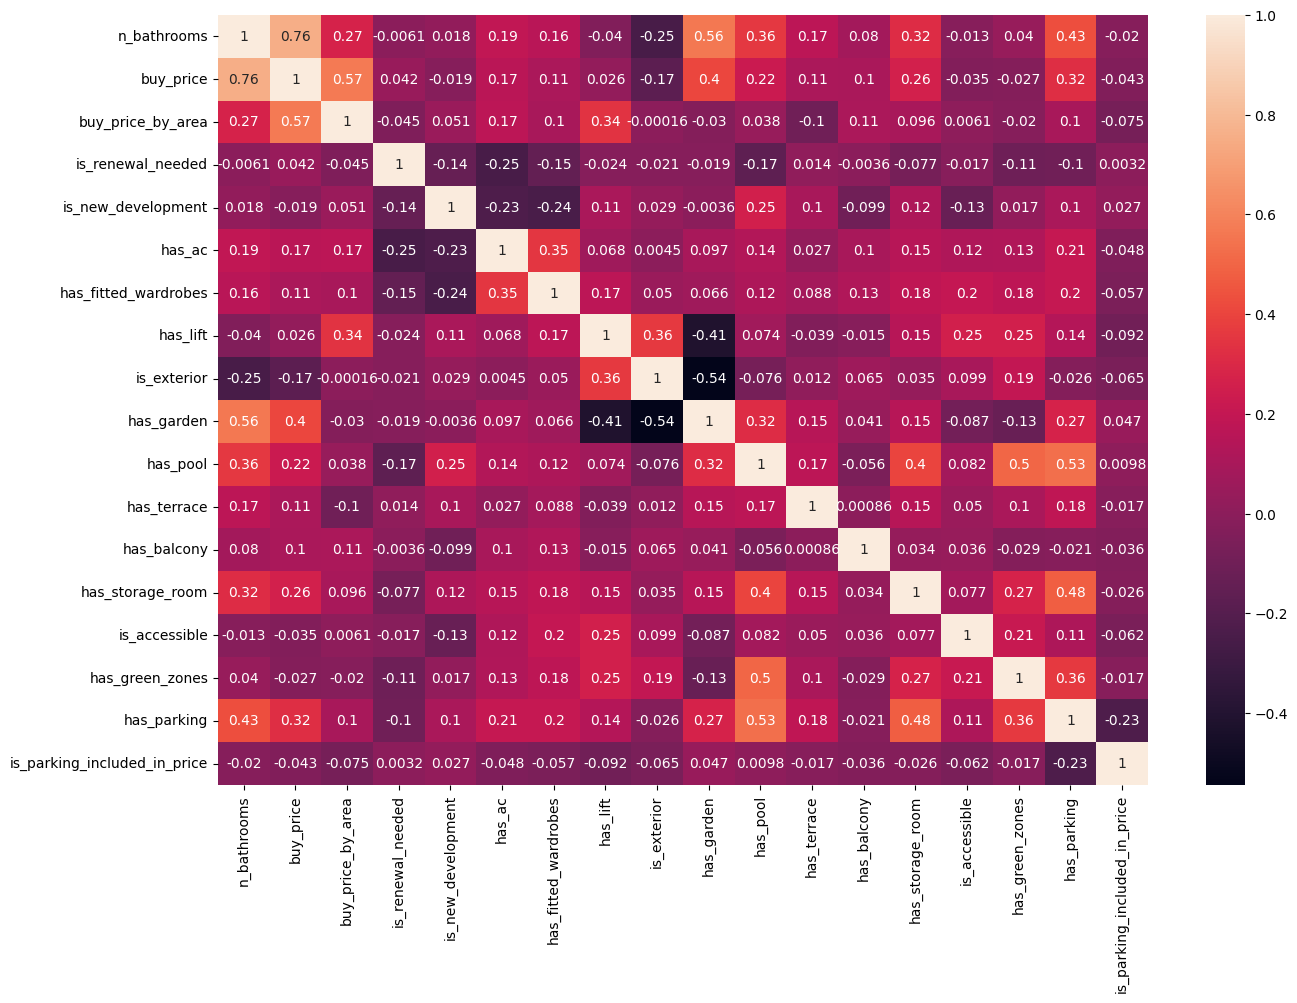

In [166]:
plt.figure(figsize= (15, 10))
sns.heatmap(train_set_remaining.corr(numeric_only= True), annot= True);

Veamos las variables numéricas con mayor correlación con nuestro target de precio objetivo.

In [167]:
corr_matrix=train_set_remaining.corr(numeric_only=True)
corr_matrix['buy_price'].sort_values(ascending=False)

buy_price                       1.000000
n_bathrooms                     0.755740
buy_price_by_area               0.569471
has_garden                      0.404199
has_parking                     0.324265
has_storage_room                0.263627
has_pool                        0.223980
has_ac                          0.165776
has_terrace                     0.108251
has_fitted_wardrobes            0.108217
has_balcony                     0.102480
is_renewal_needed               0.042451
has_lift                        0.026179
is_new_development             -0.019385
has_green_zones                -0.027410
is_accessible                  -0.034616
is_parking_included_in_price   -0.042602
is_exterior                    -0.172944
Name: buy_price, dtype: float64

Como era de espearar, parece que los metros cuadrados, los baños, habitaciones, el precio de la zona son las que más influyen el precio de compraventa.

Metemos en una lista todas las variables numericas excluyendo el target y las visualizamos con histogramas.

In [168]:
# var_num = [col for col in train_set_remaining.columns if col != target and is_numeric_dtype(train_set_remaining[col]) and ~train_set.columns.isin(columns_to_excude)]
#train_set_remaining = train_set.loc[:, ~train_set.columns.isin(columns_to_excude)]
var_num= [col for col in train_set_remaining.columns if col not in bool_transform and col not in columns_to_exclude and col not in  var_cat and col != target]

In [169]:
var_num 


['n_bathrooms', 'buy_price_by_area']

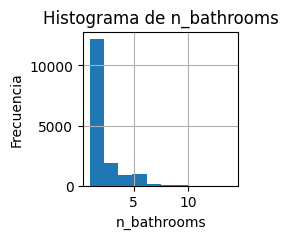

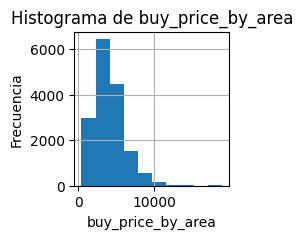

In [170]:
#var_num.hist(figsize=(8,8))


for column in var_num:
    plt.figure()
    train_set_remaining[column].hist(figsize=(2,2))
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()

A todas las VARAIBLES NUMÉRICAS que no vengan de booleanas vamos a:
  - Aplicarles una transformacíón logarítmica porque las distribuciones parecen en la mayoría agrupadas hacia la izquierda.
  - Aplicarles un StandardScaler porque están en diferentes unidades.

In [171]:
num_transform = var_num
num_transform

['n_bathrooms', 'buy_price_by_area']

In [172]:
cat_transform = var_cat
cat_transform

['house_type_id', 'energy_certificate', 'district_id']

### Creación de las parejas X,y

In [173]:
# Para hacer el pipeline
X_train = train_set.drop(train_set[[target]], axis=1)
X_test = test_set.drop(test_set[[target]], axis=1)

y_train = train_set[target]
y_test = test_set[target]

In [174]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(16160, 57)
(16160,)
(4078, 57)
(4078,)


In [175]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16160 entries, 1948 to 15796
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    16160 non-null  int64  
 1   title                         16160 non-null  object 
 2   subtitle                      16160 non-null  object 
 3   sq_mt_built                   16160 non-null  float64
 4   sq_mt_useful                  6072 non-null   float64
 5   n_rooms                       16160 non-null  int64  
 6   n_bathrooms                   16160 non-null  int32  
 7   n_floors                      1051 non-null   float64
 8   sq_mt_allotment               1000 non-null   float64
 9   latitude                      0 non-null      float64
 10  longitude                     0 non-null      float64
 11  raw_address                   12119 non-null  object 
 12  is_exact_address_hidden       16160 non-null  int32  
 13  str

In [176]:
len(columns_to_exclude)

37

## Pipeline

Vamos a crear los pipelines para el procesado.

Nos aseguramos de que todas las columnas a tratar están en el x_train

In [177]:
all_columns = num_transform + cat_transform + columns_to_exclude
missing_columns = [col for col in all_columns if col not in X_train.columns] 
if missing_columns: 
    print(f"Columnas faltantes: {missing_columns}")
else: print("Ok, no falta ninguna columna.")


Ok, no falta ninguna columna.


In [178]:
num_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one')), # Este último argumento para poder generar el DataFrame posterior
    ('SScaler', StandardScaler())
])

# Pipeline para características categóricas
cat_pipeline = Pipeline([
    ('OHEncoder', OneHotEncoder())
])

# Transformador de columnas
prepocessing = ColumnTransformer([
    
        
        ('Impute_Numeric', num_pipeline, num_transform),
        ('Process_Categorical', cat_pipeline, cat_transform),
        ('Exclude', 'drop', columns_to_exclude)
    ],
    remainder='passthrough'
)

Vemos el esquema del preprocesado.

In [179]:
prepocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('Impute_Numeric',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('SScaler',
                                                  StandardScaler())]),
                                 ['n_bathrooms', 'buy_price_by_area']),
                                ('Process_Categorical',
                                 Pipeline(steps=[('OHEncoder',
                                                  OneHotEncoder())]),
                                 ['house_type_id', 'energy_certificate',
                                  'di...
                                  'has_public_parking', 'sq_mt_allotment',
                                  'n_floors', 'title', 'street_number',
                                  'street_name', 'rent_price', 'raw_address',
                                  'is_exact_address_hidden',
                                  'is_rent_price_known', 'is_buy_price_known',
                                  'operation', 'sq_mt_useful', 'parking_price',
                                  'built_year', 'is_orientation_east',
                                  'is_orientation_south', 'is_orientation_west',
                                  'is_orientation_north',
                                  'has_individual_heating', ...])])

Entrenamos el preprocesado

In [180]:
X_train_pipe = prepocessing.fit_transform(X_train)

Visualizamos el preprocesado en un DataFrame

In [181]:

X_train_pipe_df = pd.DataFrame(X_train_pipe, columns=prepocessing.get_feature_names_out())
X_train_pipe_df.head()

,Impute_Numeric__n_bathrooms,Impute_Numeric__buy_price_by_area,Process_Categorical__house_type_id_HouseType 1: Pisos,Process_Categorical__house_type_id_HouseType 2: Casa o chalet,Process_Categorical__house_type_id_HouseType 4: Dúplex,Process_Categorical__house_type_id_HouseType 5: Áticos,Process_Categorical__energy_certificate_A,Process_Categorical__energy_certificate_B,Process_Categorical__energy_certificate_C,Process_Categorical__energy_certificate_D,...,remainder__is_exterior,remainder__has_garden,remainder__has_pool,remainder__has_terrace,remainder__has_balcony,remainder__has_storage_room,remainder__is_accessible,remainder__has_green_zones,remainder__has_parking,remainder__is_parking_included_in_price
0,0.909547,2.331985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.517697,1.772031,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.979539,-0.311173,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-0.979539,-0.642820,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.979539,-0.626149,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [182]:
X_train_pipe_df.isnull().sum() # Vemos que no hay nulos.

Impute_Numeric__n_bathrooms                                      0
Impute_Numeric__buy_price_by_area                                0
Process_Categorical__house_type_id_HouseType 1: Pisos            0
Process_Categorical__house_type_id_HouseType 2: Casa o chalet    0
Process_Categorical__house_type_id_HouseType 4: Dúplex           0
Process_Categorical__house_type_id_HouseType 5: Áticos           0
Process_Categorical__energy_certificate_A                        0
Process_Categorical__energy_certificate_B                        0
Process_Categorical__energy_certificate_C                        0
Process_Categorical__energy_certificate_D                        0
Process_Categorical__energy_certificate_E                        0
Process_Categorical__energy_certificate_F                        0
Process_Categorical__energy_certificate_G                        0
Process_Categorical__energy_certificate_en trámite               0
Process_Categorical__energy_certificate_inmueble exento       

## Entrenamiento 

Elegimos para entrenar el modelo lineal más sencillo **Regresión Lineal** y luego un ensamblado como **Random Forest** y boosting como **XGBoost** y **LightGBM**


En primer lugar, instanciaremos los modelos con ayuda de **Pipelines** y haremos un *baseline* con **Cross Validation** para tomar como referencia las siguientes métricas: 

    - R² (Coeficiente de Determinación): cuanto más alto mejor, más queda explicada la variable dependiente por las independientes.
    - MSE(Errorr Cuadrático Medio): cuanto más bajo mejor, los errores serán más pequeños. Cuanto más cercano a cero mejor.
    - MAE (Error Absoluto Medio): cuanto más bajo mejor, los errores serán más pequeños. Cuanto más cercano a cero mejor.
    - MEA (Mediana del Error Abosluto): cuanto más bajo mejor, los errores serán más pequeños. Cuanto más cercano a cero mejor.

In [183]:
linear_pipe = Pipeline(
    [('Preprocesado', prepocessing),
     ('Modelo', LinearRegression())
     ])


random_pipe = Pipeline(
    [('Preprocesado', prepocessing),
     ('Modelo', RandomForestRegressor())
     ])

xgb_pipe = Pipeline(
    [('Preprocesado', prepocessing),
     ('Modelo', XGBRegressor())
     ])

lgb_pipe = Pipeline([
    ('Preprocesado', prepocessing),
    ('Modelo', LGBMRegressor())
    ])

# Aplico la transformacion logaritmica del Target con TransformedTargetRegressor()
# crearemos una tabla para presentar los resultados.
metricas = { 
    'R2': 'r2',
    'MSE': 'neg_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'Mediana del Error Absoluto': 'neg_median_absolute_error' }
resultados = {metrica: [] for metrica in metricas} 
resultados['Modelo'] = []
modelos = ['LinealRegresor', 'RandomF', 'XGB', 'LGB']
pipe = [linear_pipe, random_pipe, xgb_pipe, lgb_pipe]
for name,pipe in zip(modelos, pipe):
  
    tt = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.exp)
    resultados['Modelo'].append(name)
    for metrica,scoring in metricas.items():
        cross_val = np.mean(cross_val_score(tt, X_train, y_train, cv=10, scoring=scoring))
        resultados[metrica].append(cross_val)
        print(f'{name} ({scoring})--> {(cross_val):.4f}')

df_resultados = pd.DataFrame(resultados) # pasamos los resultados a una tabla

# le damos formato a la tabla
df_resultados['R2'] = df_resultados['R2'].map('{:.3f}'.format)
df_resultados['MSE'] = df_resultados['MSE'].map('{:,.2f}'.format)
df_resultados['MAE'] = df_resultados['MAE'].map('{:,.2f}'.format)
df_resultados['Mediana del Error Absoluto'] = df_resultados['Mediana del Error Absoluto'].map('{:,.2f}'.format)

# ponemos el nombre del modelo al inicio de la tabla
cols = df_resultados.columns.tolist()
cols = [cols[-1]] + cols[:-1]
df_resultados = df_resultados[cols]

df_resultados # presentamos los resultados en la tabla.


LinealRegresor (r2)--> 0.8059
LinealRegresor (neg_mean_squared_error)--> -106838027617.0475
LinealRegresor (neg_mean_absolute_error)--> -154410.9497
LinealRegresor (neg_median_absolute_error)--> -63580.9682
RandomF (r2)--> 0.8481
RandomF (neg_mean_squared_error)--> -83765434515.7473
RandomF (neg_mean_absolute_error)--> -133380.8093
RandomF (neg_median_absolute_error)--> -50224.3736
XGB (r2)--> 0.8386
XGB (neg_mean_squared_error)--> -88387904713.8038
XGB (neg_mean_absolute_error)--> -139094.5294
XGB (neg_median_absolute_error)--> -54224.6820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 14544, number of used features: 51
[LightGBM] [Info] Start training from score 12.944755
[LightGBM] [Info] Auto-choosing row-wise multi-

,Modelo,R2,MSE,MAE,Mediana del Error Absoluto
0,LinealRegresor,0.806,"-106,838,027,617.05","-154,410.95","-63,580.97"
1,RandomF,0.848,"-83,765,434,515.75","-133,380.81","-50,224.37"
2,XGB,0.839,"-88,387,904,713.80","-139,094.53","-54,224.68"
3,LGB,0.842,"-87,048,547,321.39","-139,454.66","-55,124.14"


Los resultados han bajado al quitar dos variales y el R2 pasa a valor 0.8 en lugar de 1, así que por ahora lo tomamos por bueno. 

Con ayuda de `TransformedTargetRegressor()`, el mejor error es la obtenida con **LinealRegresor**, con este modelo no hace falta optimizar hiperparámetros.

Si hubiera sido otro igual hubiera tenido sentido usar un **PCA** para reducir el número de features y acelerar el proceso de entrenamiento y grid search, pero en este caso no hace falta.

In [184]:
linear_pipe = Pipeline(
    [('Preprocesado', prepocessing),
     ('Modelo', LinearRegression())
     ])

In [185]:
linear_pipe


Pipeline(steps=[('Preprocesado',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Impute_Numeric',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('SScaler',
                                                                   StandardScaler())]),
                                                  ['n_bathrooms',
                                                   'buy_price_by_area']),
                                                 ('Process_Categorical',
                                                  Pipeline(steps=[('OHEncoder',
                                                                   OneHotEncoder())]),
                                                  ['house_t...
                                                   'n_floors', 'title',
                                                   'street_number',
                                                   'street_name', 'rent_price',
                                                   'raw_address',
                                                   'is_exact_address_hidden',
                                                   'is_rent_price_known',
                                                   'is_buy_price_known',
                                                   'operation', 'sq_mt_useful',
                                                   'parking_price',
                                                   'built_year',
                                                   'is_orientation_east',
                                                   'is_orientation_south',
                                                   'is_orientation_west',
                                                   'is_orientation_north',
                                                   'has_individual_heating', ...])])),
                ('Modelo', LinearRegression())])

In [186]:
linear_pipe.fit(X_train, y_train)

Pipeline(steps=[('Preprocesado',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Impute_Numeric',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('SScaler',
                                                                   StandardScaler())]),
                                                  ['n_bathrooms',
                                                   'buy_price_by_area']),
                                                 ('Process_Categorical',
                                                  Pipeline(steps=[('OHEncoder',
                                                                   OneHotEncoder())]),
                                                  ['house_t...
                                                   'n_floors', 'title',
                                                   'street_number',
                                                   'street_name', 'rent_price',
                                                   'raw_address',
                                                   'is_exact_address_hidden',
                                                   'is_rent_price_known',
                                                   'is_buy_price_known',
                                                   'operation', 'sq_mt_useful',
                                                   'parking_price',
                                                   'built_year',
                                                   'is_orientation_east',
                                                   'is_orientation_south',
                                                   'is_orientation_west',
                                                   'is_orientation_north',
                                                   'has_individual_heating', ...])])),
                ('Modelo', LinearRegression())])

Veamos el impacto en el valor de cada una de las variables extrayendo los coeficientes del modelo de regresión de dentro del pipeline.

In [187]:
modelo_usado = linear_pipe.named_steps['Modelo'] # localizamos el modelo en los paso del pipeline.


In [188]:
coeficientes = modelo_usado.coef_ # extraemos los coeficientes


In [189]:
# Presentamos los coefs en forma de tabla.

variables = X_train_pipe_df.columns
pesos = pd.DataFrame({'Variable':variables,'Peso':coeficientes})
pesos_ordenados = pesos.sort_values(by='Peso',ascending=False)
pesos_ordenados

,Variable,Peso
6,Process_Categorical__energy_certificate_A,9.303304e+16
8,Process_Categorical__energy_certificate_C,9.303304e+16
12,Process_Categorical__energy_certificate_G,9.303304e+16
13,Process_Categorical__energy_certificate_en trá...,9.303304e+16
7,Process_Categorical__energy_certificate_B,9.303304e+16
15,Process_Categorical__energy_certificate_no ind...,9.303304e+16
14,Process_Categorical__energy_certificate_inmueb...,9.303304e+16
11,Process_Categorical__energy_certificate_F,9.303304e+16
9,Process_Categorical__energy_certificate_D,9.303304e+16
10,Process_Categorical__energy_certificate_E,9.303304e+16


Vemos que el tipo de casa y si el barrio en el que esté condiciona mucho el precio. Lo que era de esperar.
Lo que no nos queda claro es la calificación energética, que es la siguiente en importancia, para mejorar el modelo habría que estudiarla y/o eliminarla si no es necesaria.  
Luego los metros cuadrados y el precio por área son tambié muy importantes como también era esperable.

Vamos evaluar nuestro modelo contra el test a ver si los buenos resultados se mantienen.

In [190]:
# Evaluamos contra test
y_pred = linear_pipe.predict(X_test)

mae_score = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Test MAE score -->', mae_score)
print('Test R2 score -->', r2)

Test MAE score --> 267685.5465914664
Test R2 score --> 0.6761755852841909


Contra test la la métrica baja bastante más. 
Deberíamos hacer más evaluaciones.

